In [10]:
%load_ext autoreload

In [11]:
%autoreload 2

In [12]:
from pathlib import Path
import itertools 

from cycler import cycler

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.cm as mcm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

from matplotlib import rcParams

from scipy.spatial.distance import pdist, squareform

import numpy as np
import pandas as pd
import cmocean
import xarray as xr

import metpy
from metpy.interpolate import interpolate_to_grid

import geopandas as gpd


import intro_plots as ip
from papercolors import colordict as pcd
import topology as tp 

paper_path = Path('../figures/')


rcParams['font.family'] = 'dejavu sans'
rcParams['figure.dpi'] = 200

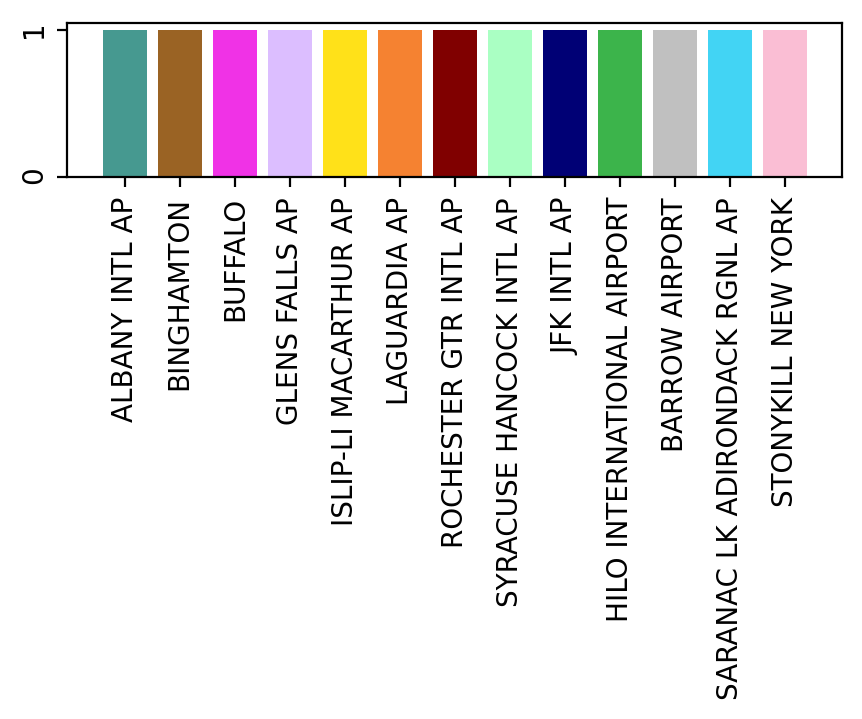

In [2]:
fig, ax = plt.subplots(figsize=(5,1))
ax.bar(ip.airports.keys(), 1, color=[v['color'] for k,v in ip.airports.items()]) 
ax.tick_params(rotation=90)

In [3]:
ny_all = pd.read_csv("nydata.csv", parse_dates=['DATE'])
#[name for name in ny_all['NAME'].unique() if (('AP' in name) or ('INTL' in name))]

In [4]:
ny = ny_all[ny_all['NAME'].isin(ip.ssubset)].copy().fillna(0)

ny['DATES'] = pd.to_datetime(ny['DATE'])

ny['TEMP (°F)'] = ny['TAVG'].apply(lambda x: f"{x:2.2f}")
ny['PRCP (in.)'] = ny['PRCPI'].apply(lambda x: f"{x:1.2f}")    

In [5]:
ny['NAME'].unique()

array(['ALBANY INTL AP', 'BINGHAMTON', 'BUFFALO', 'GLENS FALLS AP',
       'ISLIP-LI MACARTHUR AP', 'JFK INTL AP', 'LAGUARDIA AP',
       'SARANAC LK ADIRONDACK RGNL AP', 'STONYKILL NEW YORK',
       'SYRACUSE HANCOCK INTL AP'], dtype=object)

In [6]:
date = '02-10-2022'
time_series = ny.copy()
time_series['DATE'] = pd.to_datetime(time_series['DATES'])
all_fields = ny[ny['DATE'] == date].set_index('NAME').reset_index()
all_fields

,NAME,LATITUDE,LONGITUDE,DATE,PRCP,TAVG,TAVGF,PRCPI,DATES,TEMP (°F),PRCP (in.)
0,ALBANY INTL AP,42.7472,-73.7992,2022-02-10,5.0,35.0,38.30,0.019685,2022-02-10,35.00,0.02
1,BINGHAMTON,42.1997,-75.9847,2022-02-10,0.0,24.0,36.32,0.000000,2022-02-10,24.00,0.00
2,BUFFALO,42.9489,-78.7367,2022-02-10,8.0,26.0,36.68,0.031496,2022-02-10,26.00,0.03
3,GLENS FALLS AP,43.3386,-73.6103,2022-02-10,8.0,3.0,32.54,0.031496,2022-02-10,3.00,0.03
4,ISLIP-LI MACARTHUR AP,40.7939,-73.1019,2022-02-10,0.0,40.0,39.20,0.000000,2022-02-10,40.00,0.00
5,JFK INTL AP,40.6392,-73.7639,2022-02-10,0.0,51.0,41.18,0.000000,2022-02-10,51.00,0.00
6,LAGUARDIA AP,40.7794,-73.8803,2022-02-10,0.0,63.0,43.34,0.000000,2022-02-10,63.00,0.00
7,SARANAC LK ADIRONDACK RGNL AP,44.3928,-74.2028,2022-02-10,10.0,0.0,0.00,0.039370,2022-02-10,0.00,0.04
8,STONYKILL NEW YORK,41.5000,-73.9000,2022-02-10,0.0,29.0,37.22,0.000000,2022-02-10,29.00,0.00
9,SYRACUSE HANCOCK INTL AP,43.1111,-76.1039,2022-02-10,8.0,53.0,41.54,0.031496,2022-02-10,53.00,0.03


In [7]:
nyg = ny_all[ny_all['DATE']==date]
nygeo = gpd.GeoDataFrame(nyg, geometry=gpd.points_from_xy(nyg['LONGITUDE'], nyg['LATITUDE']), crs='EPSG:4269')
gdf = gpd.read_file('s_22mr22.zip')
nyshp = gdf[gdf['STATE'].str.match('NY')]

In [8]:
px, py, prcp = interpolate_to_grid(nygeo['LONGITUDE'].values, nygeo['LATITUDE'].values, nygeo['PRCPI'].values, 
                                   interp_type='barnes', minimum_neighbors=3, 
                                         search_radius=.25, hres=.025, gamma=1)

In [9]:
sample = all_fields[['NAME', 'TEMP (°F)','PRCP (in.)']]

In [10]:
timeseries = {k:v.set_index('DATE') for k, v in time_series[['NAME','DATE', 'PRCPI']].groupby('NAME')}

In [11]:
all_fields[['NAME', 'LATITUDE', 'LONGITUDE', 'TAVG']]

,NAME,LATITUDE,LONGITUDE,TAVG
0,ALBANY INTL AP,42.7472,-73.7992,35.0
1,BINGHAMTON,42.1997,-75.9847,24.0
2,BUFFALO,42.9489,-78.7367,26.0
3,GLENS FALLS AP,43.3386,-73.6103,3.0
4,ISLIP-LI MACARTHUR AP,40.7939,-73.1019,40.0
5,JFK INTL AP,40.6392,-73.7639,51.0
6,LAGUARDIA AP,40.7794,-73.8803,63.0
7,SARANAC LK ADIRONDACK RGNL AP,44.3928,-74.2028,0.0
8,STONYKILL NEW YORK,41.5000,-73.9000,29.0
9,SYRACUSE HANCOCK INTL AP,43.1111,-76.1039,53.0


In [12]:
mcolors.to_hex(cmocean.cm.rain(0))

'#eeedf3'

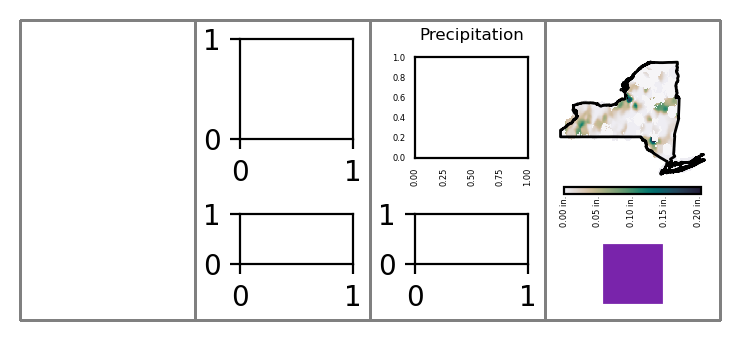

In [13]:
fig = plt.figure(figsize=(3.5, 1.5), linewidth=1, layout='compressed')
figs = fig.subfigures(1,4, wspace=0)
for subfig in figs:
    #fig0.frameon=True
    subfig.set_edgecolor('gray')
    subfig.set_linewidth(.5)


axf0 = figs[1].subplot_mosaic([['scatter'], ['k0']], gridspec_kw={'height_ratios':[2,1]})
#tp.make_table(axf0['table'], axf0['k0'], sample)

axf1 = figs[2].subplot_mosaic([['timeseries'],['k1']], gridspec_kw={'height_ratios':[2,1]})
#tp.make_timeseries(axf1['timeseries'], axf1['k1'], timeseries)
axf1['timeseries'].set_title('Precipitation', fontsize=6)
axf1['timeseries'].tick_params(labelsize=3, length=0
                              )
axf1['timeseries'].xaxis.set_tick_params(rotation=90)
axf1['timeseries'].yaxis.set_major_formatter("{:0.1f}".format)

axf2 = figs[3].subplot_mosaic([['map'], ['k2']], gridspec_kw={'height_ratios':[2,1]})

cmap = cmocean.cm.rain
nyshp.plot(ax=axf2['map'],  facecolor='#f6f5f7', edgecolor='none')
im = axf2['map'].pcolormesh(px, py, prcp, cmap=cmap)
nyshp.plot(ax=axf2['map'],  facecolor='none', edgecolor='k')
cb = fig.colorbar(im, ax=axf2['map'], fraction=.045,orientation='horizontal',
                  location='bottom')
#axf2['map'].set_title("Precipitation", fontsize=6)
cb.ax.tick_params(labelsize=3, length=0, pad=0.5,rotation=90)
cb.ax.xaxis.set_major_formatter("{:0.2f} in.".format)
axf2['map'].axis('off')
           
           
axf2['k2'].add_patch(mpatches.Rectangle((.25/2,.25-.25/2), .75, .75, color=pcd['base']))
axf2['k2'].set_aspect('equal')
axf2['k2'].axis('off')
fig.savefig(paper_path/'k_different_types.png')

In [ ]:
cb.ax.tick_params?

In [1]:
a = {'a':[1,2,3]}

In [2]:
a

{'a': [1, 2, 3]}

In [6]:
str(a.keys())

"dict_keys(['a'])"

In [9]:
for i in a.items():
    print(i)

('a', [1, 2, 3])


In [13]:
x = [1,2,3]

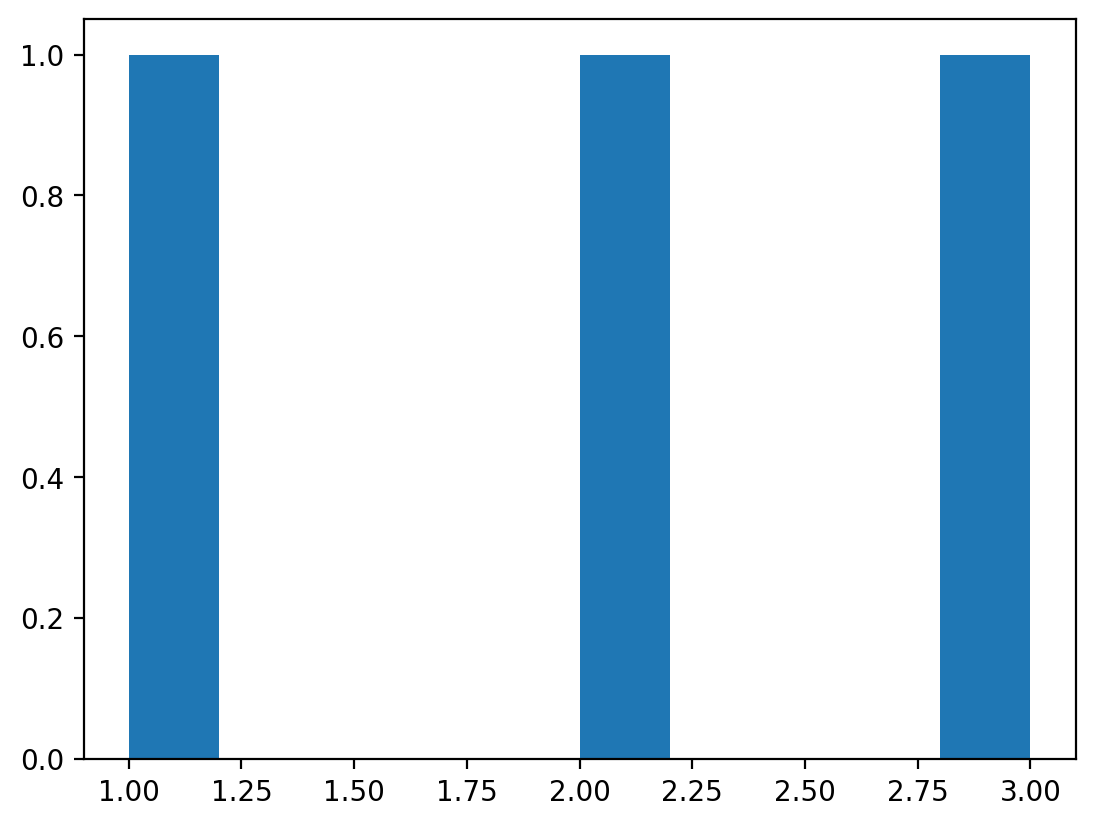

In [16]:
hist, bins, patches = plt.figure().subplots().hist(x)

In [20]:
patches[0].get_edgecolor()

(0.0, 0.0, 0.0, 0.0)

In [47]:
mcolors.to_rgba_array((0,0,0,0))

array([[0., 0., 0., 0.]])

In [29]:
patches[0].get_edgecolor()

(0.0, 0.0, 0.0, 0.0)

In [43]:
mcolors.same_color(['none'], [(0,0,0,0)])

True

In [41]:
mcolors.same_color('none', (0, 0, 0, 0))

False

In [49]:
mcolors.to_rgba_array(['none'])

array([[0., 0., 0., 0.]])

In [100]:
mcolors.to_rgba_array('none')

array([], shape=(0, 4), dtype=float64)

In [101]:
mcolors.to_rgba('none')

(0.0, 0.0, 0.0, 0.0)

In [52]:
%pdb




Automatic pdb calling has been turned ON


array([], shape=(0, 4), dtype=float64)

In [53]:
mcolors.to_rgba_array('none')

array([], shape=(0, 4), dtype=float64)

In [54]:
c = 'none'

In [55]:
isinstance(c, tuple)

False

In [56]:
isinstance(c, np.ndarray)

False

In [59]:
import matplotlib.cbook as cbook

In [62]:
cbook._str_lower_equal([c], "none")

False

In [61]:
np.zeros((0, 4), float)

array([], shape=(0, 4), dtype=float64)

In [63]:
mcolors.to_rgba('none')

(0.0, 0.0, 0.0, 0.0)

In [93]:
np.zeros((0,4), float).shape

(0, 4)

In [99]:
np.array((0, 0, 0, 0), float).T.shape

(4,)

In [102]:
import matplotlib
matplotlib.__version__

'3.8.2'